# Synthetic data

In [1]:
!pwd
import os
# os.chdir('..') # for server this isnt reqd
from bilevel.synth_datagen import SynthGenLinear

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/home/jupyter-kriach/md_github_lat/multigroupcode/multigroup-code


In [2]:
import pickle
def save_ob(name, obj):
    with open(name, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_ob(name):
    with open(name, 'rb') as handle:
        obj = pickle.load(handle)
    return obj

In [3]:
def performance_diff(ds_obj):
    df_res = pd.concat([ds_obj.df_base_meansd, ds_obj.df_Anh_meansd], axis=1)
    df_res['base_minus_Anh'] = df_res['mean_base'] - df_res['mean_Anh']
    df_res['discount_from_base'] = (df_res['base_minus_Anh'] / df_res['mean_base'])*100
    return df_res

In [4]:
# # call only one time, used the saved syn_ob below
# params = {'samples': 100000, 'dim':20, 
#         'group_dict': {'SEX':['male', 'female'], 'RACE': ['white', 'black', 'two-or-more','some-other', 'asian', 'native-am']},
#         'prob_dict': {'SEX': [0.5, 0.5], 'RACE': [0.61, 0.12, 0.1, 0.08, 0.06, 0.03]},
#         'feat_lo': 0.0, 'feat_hi': 1.0, 'w_lo': 0.0, 'w_hi': 1.0,
#         'add_linear_mapping': True, 'add_quad_mapping' : False, 
#         'S_lo': 0.0, 'S_hi':0.0,
#         'label_noise_width':0.16, 'drop_sensitive':False, 'fixed_seed':42,
#         }
# syn_ob = SynthGenLinear(**params)
# print(syn_ob.dperm, np.array(syn_ob.all_groupnames)[syn_ob.dperm])
# df = syn_ob.df
params = {'samples': 100000, 'dim':20, 
        'group_dict': {'SHAPE':['circle', 'square', 'triangle'], 'COLOR': ['green', 'red', 'blue'], 'TEXTURE':['rough', 'smooth']},
        'prob_dict': {'SHAPE': [0.5, 0.3, 0.2], 'COLOR': [0.6, 0.3, 0.1], 'TEXTURE': [0.6, 0.4]},
        'feat_lo': 0.0, 'feat_hi': 1.0, 'w_lo': 0.0, 'w_hi': 1.0,
        'add_linear_mapping': True, 'add_quad_mapping' : False,
        'S_lo': 0.0, 'S_hi':0.0,
        'label_noise_width':0.16, 'drop_sensitive':False, 'fixed_seed':42,
        }
syn_ob = SynthGenLinear(**params)
print(syn_ob.dperm, np.array(syn_ob.all_groupnames)[syn_ob.dperm])
df = syn_ob.df

[0 7 6 1 3 5 2 4] ['circle' 'smooth' 'rough' 'square' 'green' 'blue' 'triangle' 'red']


In [5]:
save_ob('syn_ob_neutral_exploss.pickle', syn_ob)

In [6]:
print(df.columns)
filter_feature = [col for col in df if col.startswith('x')]
filter_label = [col for col in df if col.startswith('y')]
filter_group = [col for col in df if col.startswith('g')]
print(filter_feature, filter_label, filter_group)

Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9',
       'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18',
       'x_19', 'g_circle', 'g_square', 'g_triangle', 'g_green', 'g_red',
       'g_blue', 'g_rough', 'g_smooth', 'y_circle', 'y_square', 'y_triangle',
       'y_green', 'y_red', 'y_blue', 'y_rough', 'y_smooth', 'y_mean_active',
       'y_min_active', 'y_max_active', 'y_dperm_active'],
      dtype='object')
['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19'] ['y_circle', 'y_square', 'y_triangle', 'y_green', 'y_red', 'y_blue', 'y_rough', 'y_smooth', 'y_mean_active', 'y_min_active', 'y_max_active', 'y_dperm_active'] ['g_circle', 'g_square', 'g_triangle', 'g_green', 'g_red', 'g_blue', 'g_rough', 'g_smooth']


## Note about features and labels
- x_0...x_19 are the features, y_mean, min, max, dperm are the labels
- also include group membership in features!, group memberships are
    Race groups, Sex groups

In [7]:
syn_ob.A_t.shape

(100000, 8)

In [8]:
syn_ob.A_t.sum(axis=0), syn_ob.all_groupnames

(array([49934., 30063., 20003., 59890., 30063., 10047., 59927., 40073.]),
 ['circle', 'square', 'triangle', 'green', 'red', 'blue', 'rough', 'smooth'])

In [9]:
A_t = pd.DataFrame(syn_ob.A_t, columns = syn_ob.all_groupnames) # A_t dataframe
A_t['always_on'] = 1

In [10]:
A_t.sum(axis=0)

circle        49934.0
square        30063.0
triangle      20003.0
green         59890.0
red           30063.0
blue          10047.0
rough         59927.0
smooth        40073.0
always_on    100000.0
dtype: float64

In [11]:
df_mean = df[filter_feature+filter_group + ['y_mean_active']]
df_min = df[filter_feature+filter_group + ['y_min_active']]
df_max = df[filter_feature+filter_group + ['y_max_active']]
df_dperm = df[filter_feature+filter_group + ['y_dperm_active']]

In [12]:
from bilevel.Groupwise_seedruns import BuildGroupwise_diffseeds

## y_mean

In [13]:
%%time
ds_ymean = BuildGroupwise_diffseeds(df_mean, 'y_mean_active', A_t) # different seeds object
ds_ymean.build_all_seeds()
ds_ymean.build_df_res()
ds_ymean.build_regret_curve()

100%|██████████| 100000/100000 [00:14<00:00, 6778.82it/s]


CPU times: user 7min 10s, sys: 9.83 s, total: 7min 20s
Wall time: 3min 27s


In [14]:
save_ob('syn_ymean_exploss.pickle', ds_ymean)

## y_min

In [15]:
%%time
ds_ymin = BuildGroupwise_diffseeds(df_min, 'y_min_active', A_t) # different seeds object
ds_ymin.build_all_seeds()
ds_ymin.build_df_res()
ds_ymin.build_regret_curve()

100%|██████████| 100000/100000 [00:14<00:00, 6749.15it/s]


CPU times: user 7min 23s, sys: 11.1 s, total: 7min 34s
Wall time: 3min 30s


In [16]:
save_ob('syn_ymin_exploss.pickle', ds_ymin)

In [19]:
# pd.concat([ds_ymin.df_base_meansd, ds_ymin.df_Anh_meansd], axis=1)

## y_max

In [17]:
ds_ymax = BuildGroupwise_diffseeds(df_max, 'y_max_active', A_t) # different seeds object
ds_ymax.build_all_seeds()
ds_ymax.build_df_res()
ds_ymax.build_regret_curve()

100%|██████████| 100000/100000 [00:14<00:00, 6686.32it/s]


In [18]:
save_ob('syn_ymax_exploss.pickle', ds_ymax)

## y_dperm

In [19]:
ds_ydperm = BuildGroupwise_diffseeds(df_dperm, 'y_dperm_active', A_t) # different seeds object
ds_ydperm.build_all_seeds()
ds_ydperm.build_df_res()
ds_ydperm.build_regret_curve()

100%|██████████| 100000/100000 [00:14<00:00, 6715.51it/s]


In [20]:
save_ob('syn_ydperm_exploss.pickle', ds_ydperm)

In [21]:
ds_ydperm.regret_Base_groupwise_array[-1].mean(axis=0), ds_ydperm.regret_Anh_groupwise_array[-1].mean(axis=0)

AttributeError: 'list' object has no attribute 'mean'

## checks which aggregation is the best for Anh

In [24]:
performance_diff(ds_ymean)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
circle,33.494734,0.188104,24.092276,0.146836,9.402459,28.071453
square,22.609174,0.183323,14.968268,0.144387,7.640906,33.795601
triangle,19.687635,0.135289,11.188358,0.058791,8.499277,43.170636
green,37.944748,0.115058,26.055341,0.119144,11.889407,31.333472
red,25.025245,0.147233,17.027825,0.134624,7.997420,31.957411
blue,12.821551,0.058277,7.165736,0.096028,5.655815,44.111783
rough,43.580828,0.193940,28.787631,0.262375,14.793197,33.944278
smooth,32.210716,0.180749,21.461271,0.247904,10.749445,33.372263
always_on,75.791544,0.048489,50.248902,0.145347,25.542642,33.701177


In [25]:
performance_diff(ds_ymin)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
circle,141.912945,0.444123,86.280720,0.549380,55.632224,39.201656
square,99.891018,0.446531,43.396674,0.082543,56.494344,56.555980
triangle,51.072475,0.232898,35.623192,0.362128,15.449282,30.249723
green,139.854670,0.424550,88.453676,0.463889,51.400994,36.753148
red,106.961597,0.556744,49.114441,0.053007,57.847156,54.082173
blue,46.060170,0.183587,27.732469,0.067635,18.327701,39.790780
rough,185.519570,0.194985,98.637952,0.412558,86.881618,46.831511
smooth,107.356867,0.184684,66.662635,0.381728,40.694232,37.905570
always_on,292.876437,0.066336,165.300586,0.448172,127.575851,43.559616


In [26]:
performance_diff(ds_ymax)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
circle,76.847733,0.450936,49.638191,0.090566,27.209542,35.407085
square,57.142333,0.294241,36.683324,0.043177,20.459009,35.803595
triangle,36.574547,0.177325,25.525589,0.053948,11.048958,30.209420
green,96.894971,0.125421,63.235392,0.191448,33.659579,34.738211
red,55.561746,0.140541,34.859406,0.250777,20.702339,37.260059
blue,18.107896,0.050332,13.752305,0.091690,4.355591,24.053546
rough,75.825463,0.482030,54.046915,0.327331,21.778548,28.721946
smooth,94.739150,0.452727,57.800188,0.307854,36.938961,38.990176
always_on,170.564613,0.071068,111.847103,0.119664,58.717510,34.425376


In [27]:
performance_diff(ds_ydperm)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
circle,122.283852,1.112594,25.788486,0.074269,96.495367,78.910964
square,94.369627,0.699002,36.592544,0.064355,57.777083,61.224236
triangle,62.324181,0.430190,24.578524,0.042482,37.745657,60.563422
green,166.792320,0.150048,52.176369,0.168378,114.615951,68.717763
red,83.644437,0.135781,25.878120,0.190773,57.766318,69.061756
blue,28.540903,0.060170,8.905064,0.077964,19.635838,68.798939
rough,141.711030,0.648412,45.210034,0.270075,96.500997,68.097026
smooth,137.266630,0.614417,41.749520,0.254320,95.517110,69.585091
always_on,278.977660,0.062967,86.959554,0.076294,192.018107,68.829205


In [31]:
# also check that df mean, min, max, dperm are same except ycol

circle 49934


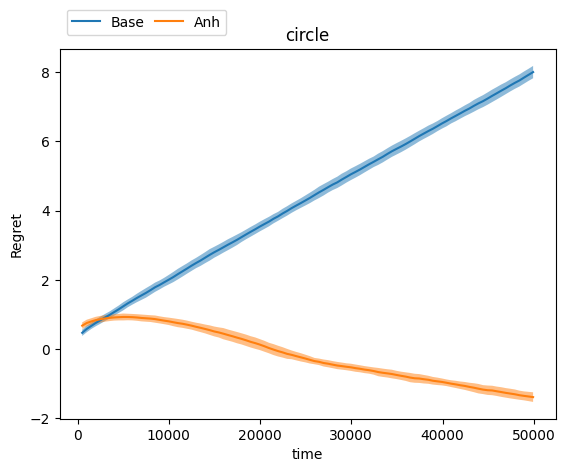

square 30063


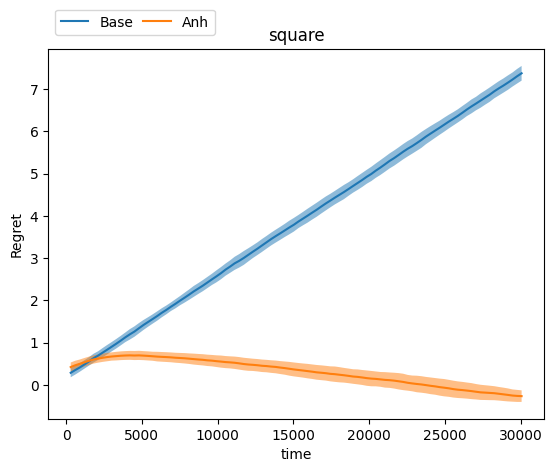

triangle 20003


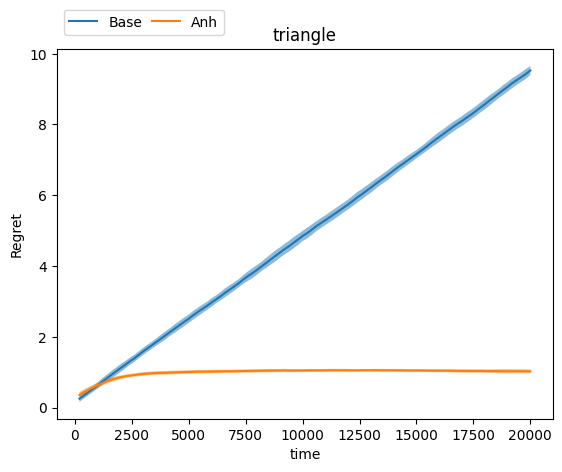

green 59890


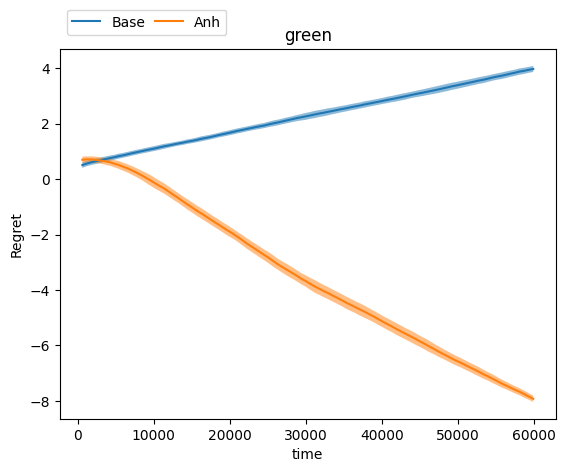

red 30063


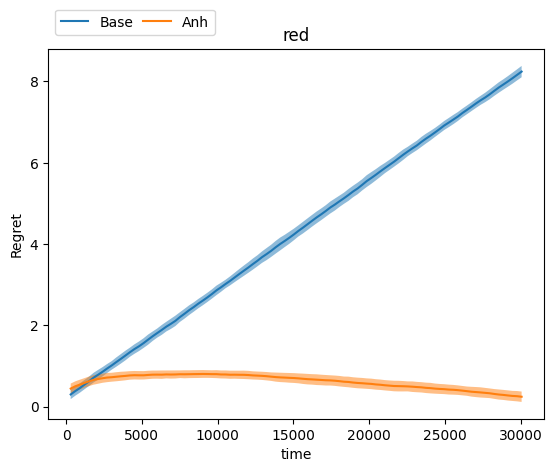

blue 10047


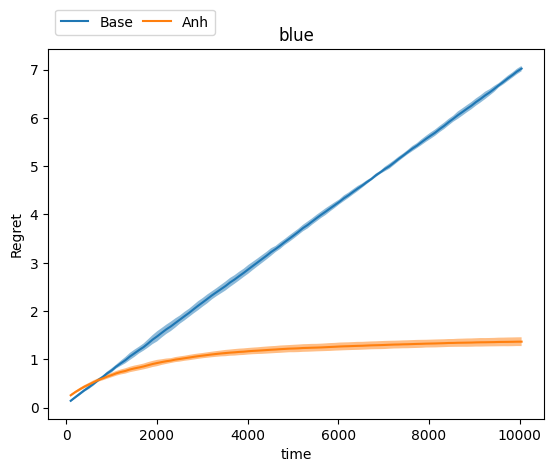

rough 59927


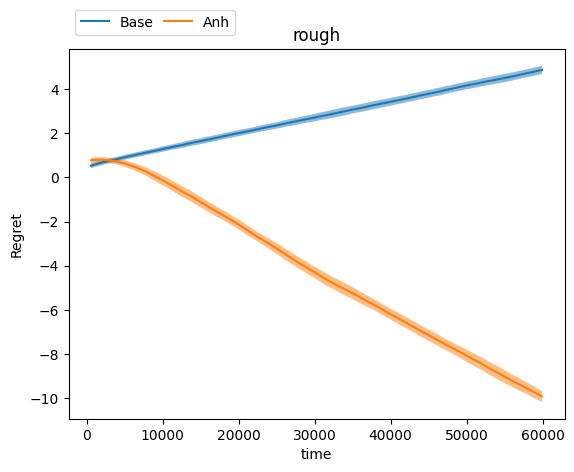

smooth 40073


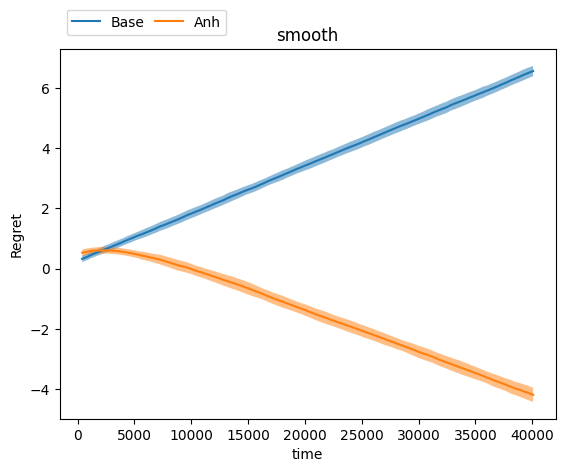

always_on 100000


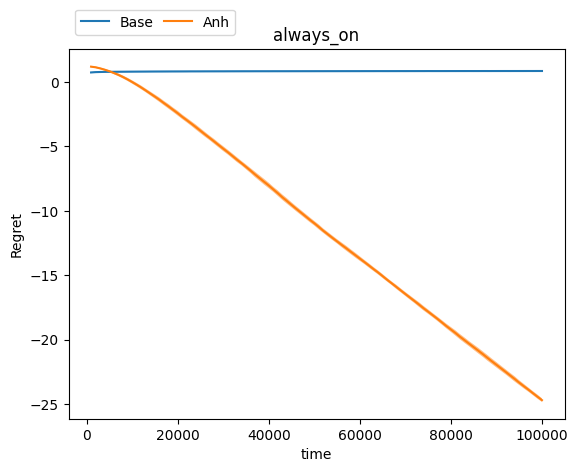

circle 49934


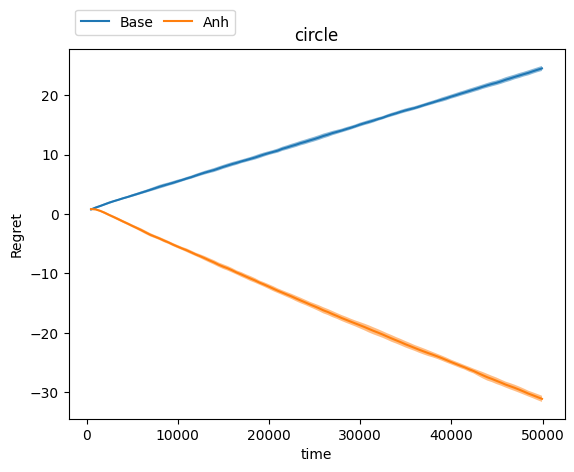

square 30063


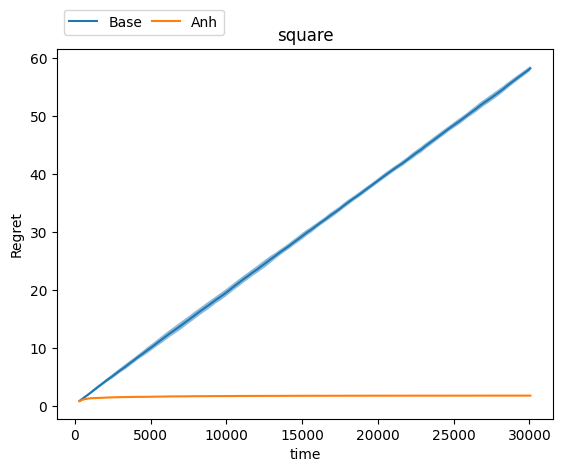

triangle 20003


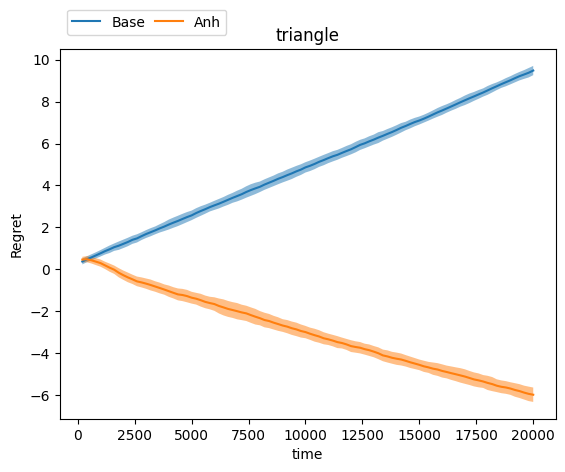

green 59890


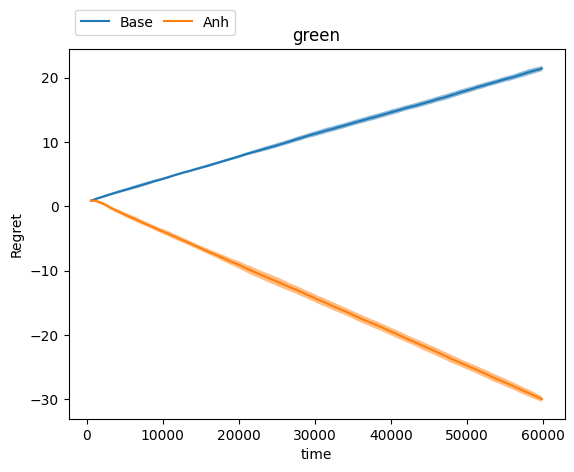

red 30063


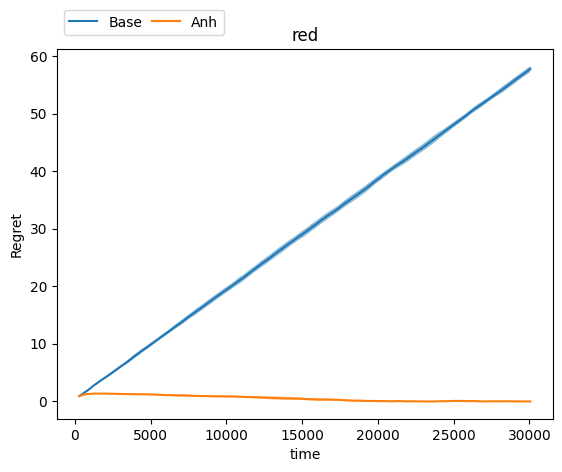

blue 10047


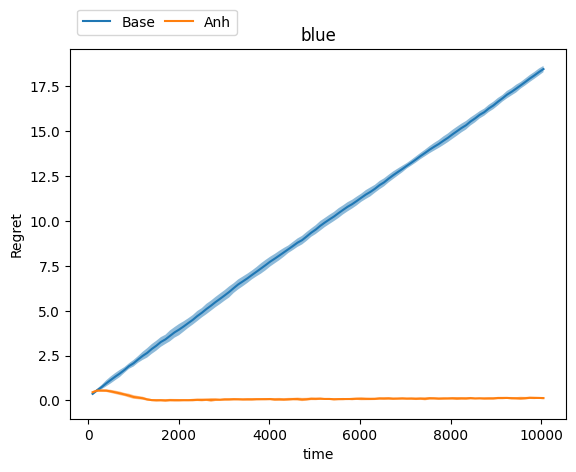

rough 59927


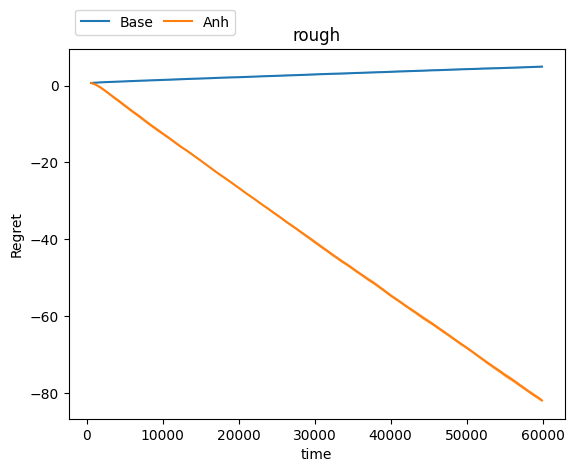

smooth 40073


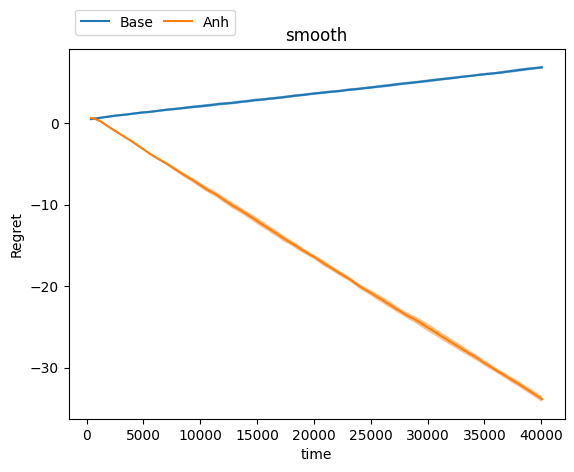

always_on 100000


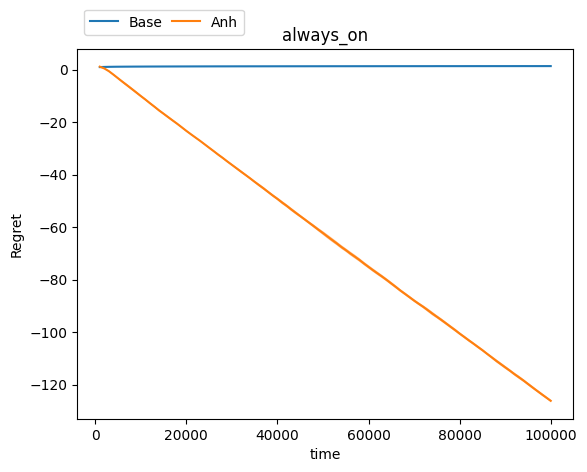

circle 49934


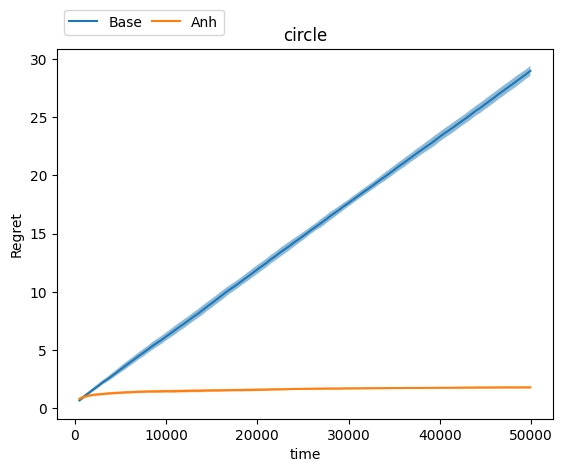

square 30063


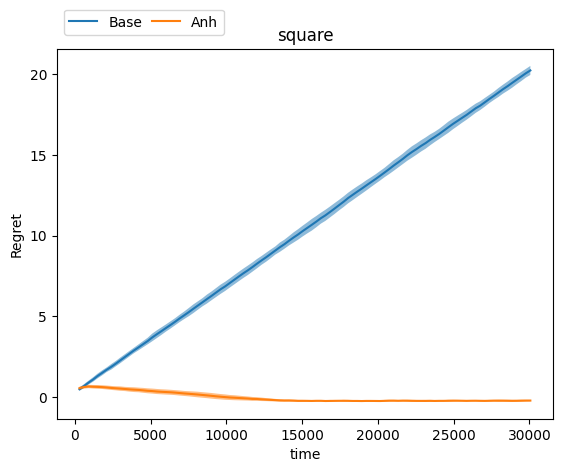

triangle 20003


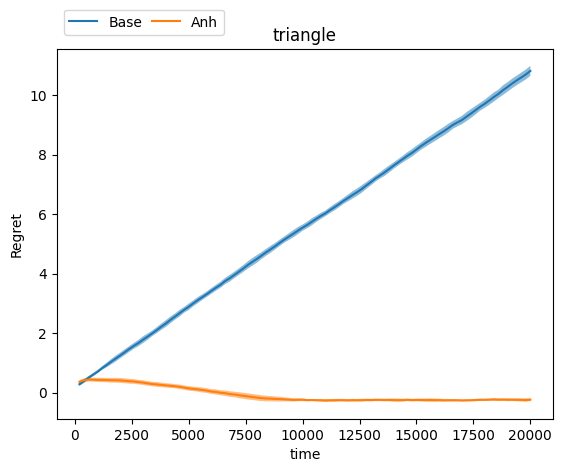

green 59890


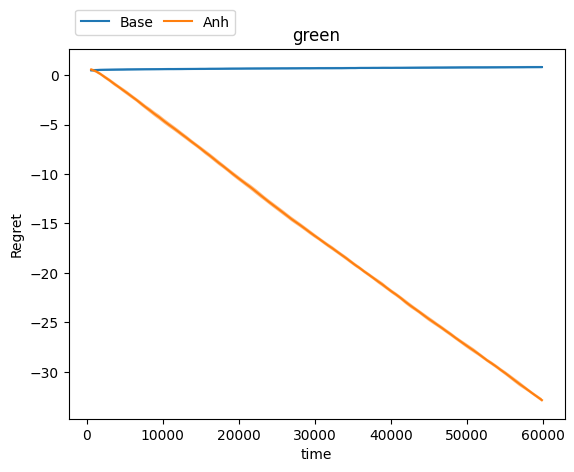

red 30063


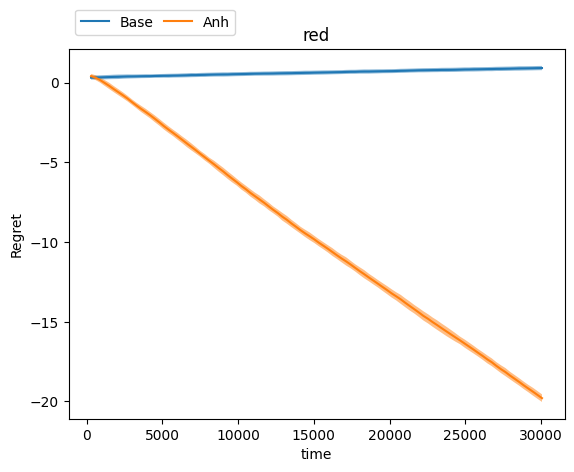

blue 10047


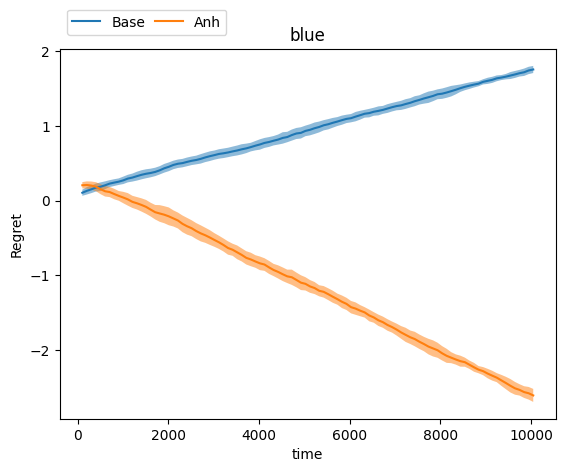

rough 59927


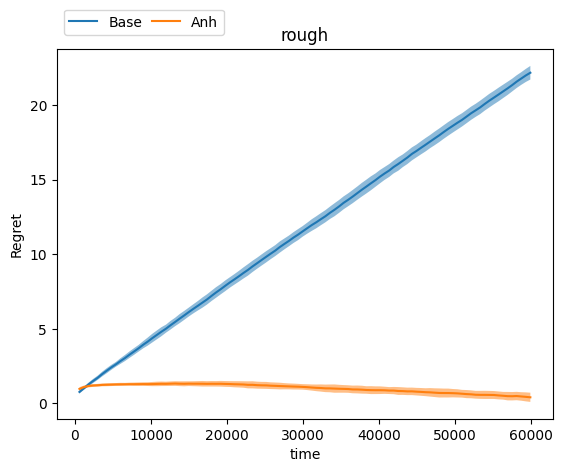

smooth 40073


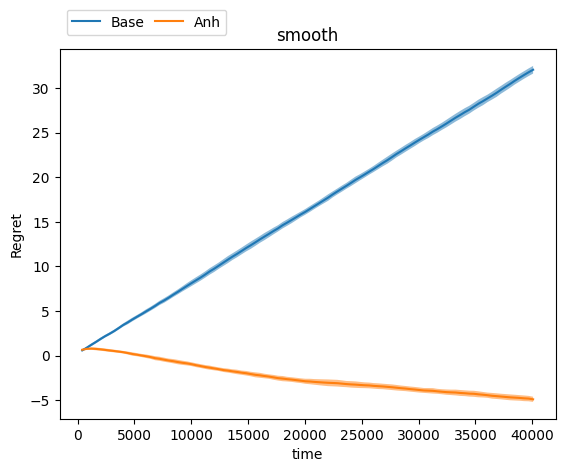

always_on 100000


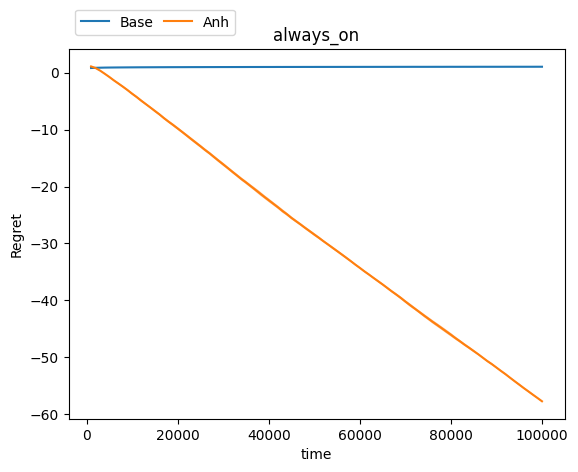

circle 49934


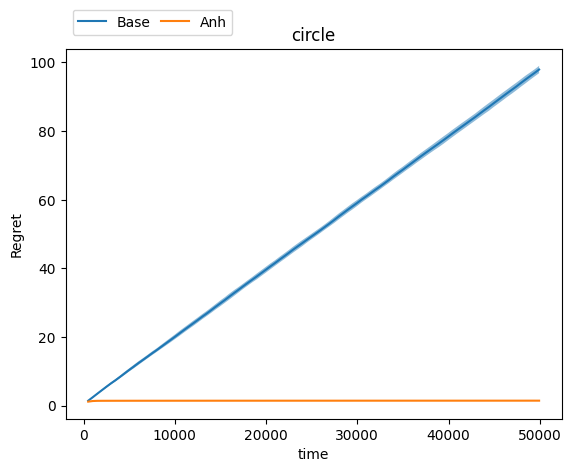

square 30063


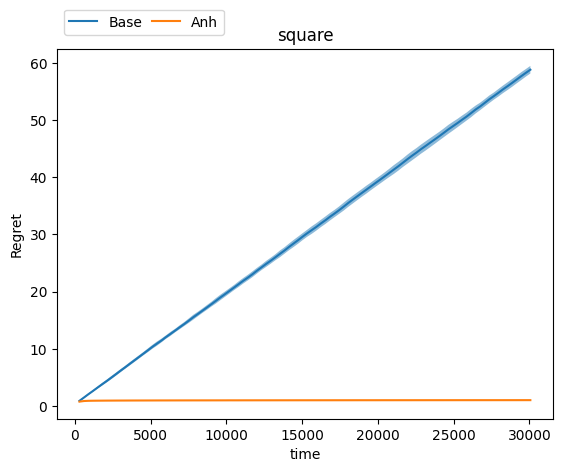

triangle 20003


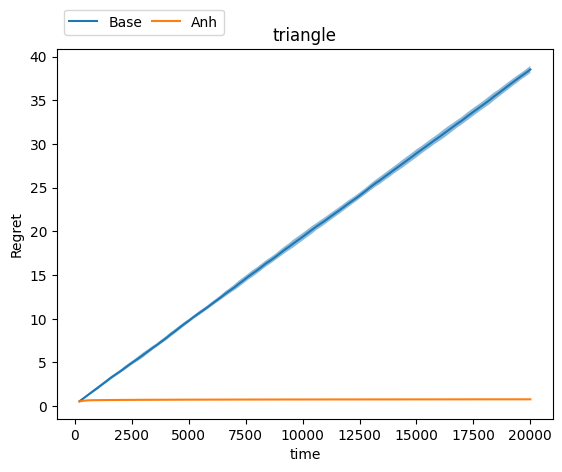

green 59890


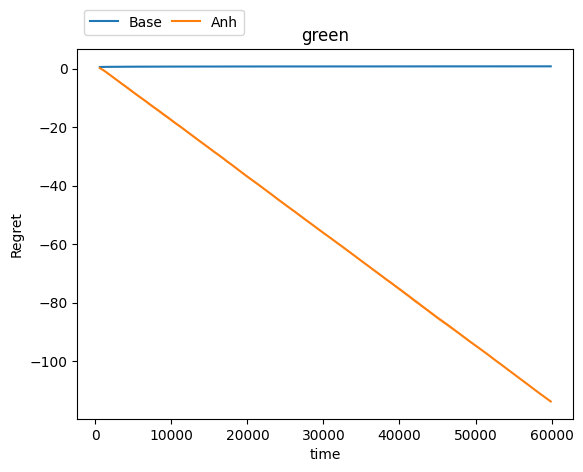

red 30063


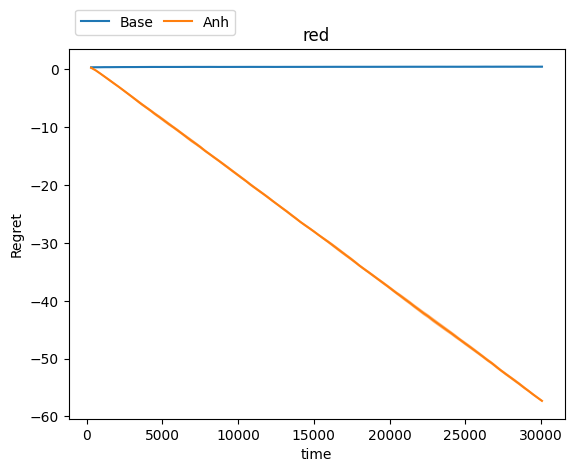

blue 10047


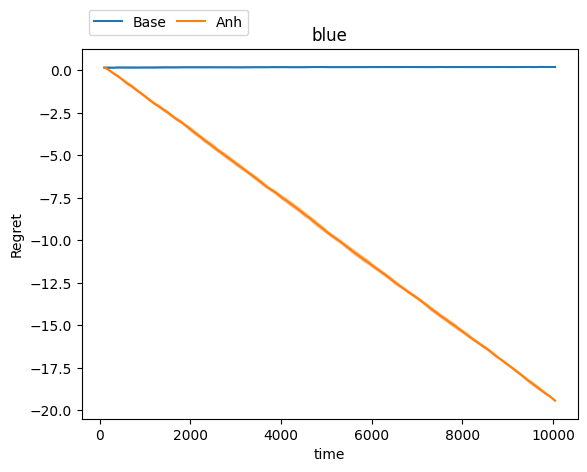

rough 59927


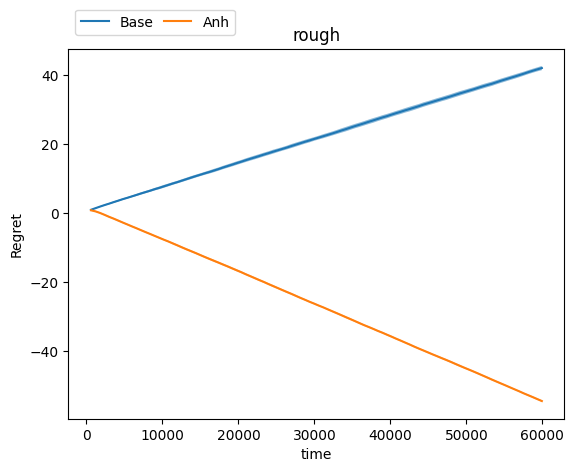

smooth 40073


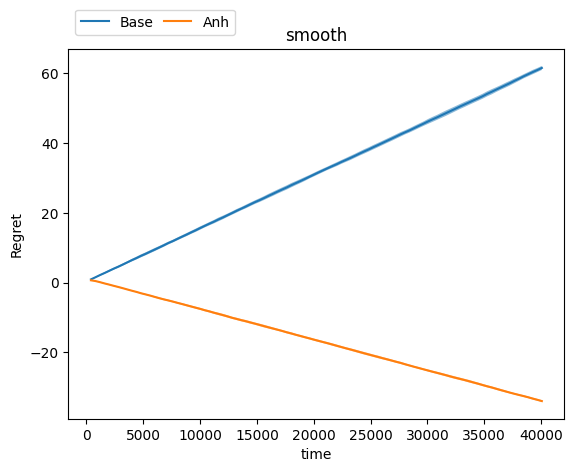

always_on 100000


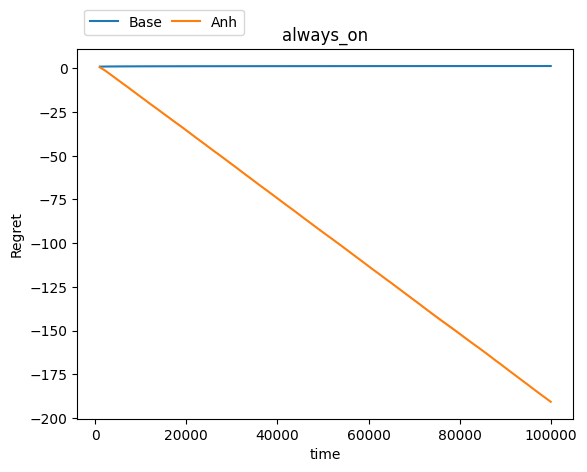

In [29]:
from bilevel.Groupwise_seedruns import plot_regret_curve_with_std
# ds_ymean = load_ob('syn_ymean_seeds.pickle')
plot_regret_curve_with_std(ds_ymean, 'synth_ymean')

# ds_ymin = load_ob('syn_ymin_seeds.pickle')
plot_regret_curve_with_std(ds_ymin, 'synth_ymin')

# ds_ymax = load_ob('syn_ymax_seeds.pickle')
plot_regret_curve_with_std(ds_ymax, 'synth_ymax')


# ds_ydperm = load_ob('syn_ydperm_seeds.pickle')
plot_regret_curve_with_std(ds_ydperm, 'synth_ydperm')